# A Review of the Reviewers - Exposing Beer Reviewers’ Biases

This jupyter notebook contains our initial data analyses and data handling regarding the Beer datasets BeerAdvocate and RateBeer. As outlined in project proposal, we investigate the reviewers bias regarding three aspects. The notebook is structured in the following way:

1. [Influence of reviewer's experience](#1-influence-of-revierws-experience)
2. [Spatial reviewer bias](#2-spatial-reviewer-bias)
3. [Temporal/Seasonal reviewer bias](#3-Influence-of-the-season)

## 1. Influence of reviewer's experience 

### 1.1 Analysis of experience based on amount of reviews

In this part of the analysis, we want to investigate how the ratings provided by a user change over time. This can be shown by plotting the rating number on the x-axis and the relative distribution of ratings on the y-axis. In this section we would also have a second axis showing the total amount of ratings provided at the given rating number.

In [1]:
%load_ext autoreload
%autoreload 2
from src.models.change_in_rating_distribution import *
from src.data.some_dataloader import *
from src.models.top10_beers_distribution import top10beers_ratings

In [2]:
df_ba_ratings, df_rb_ratings = load_rating_data()

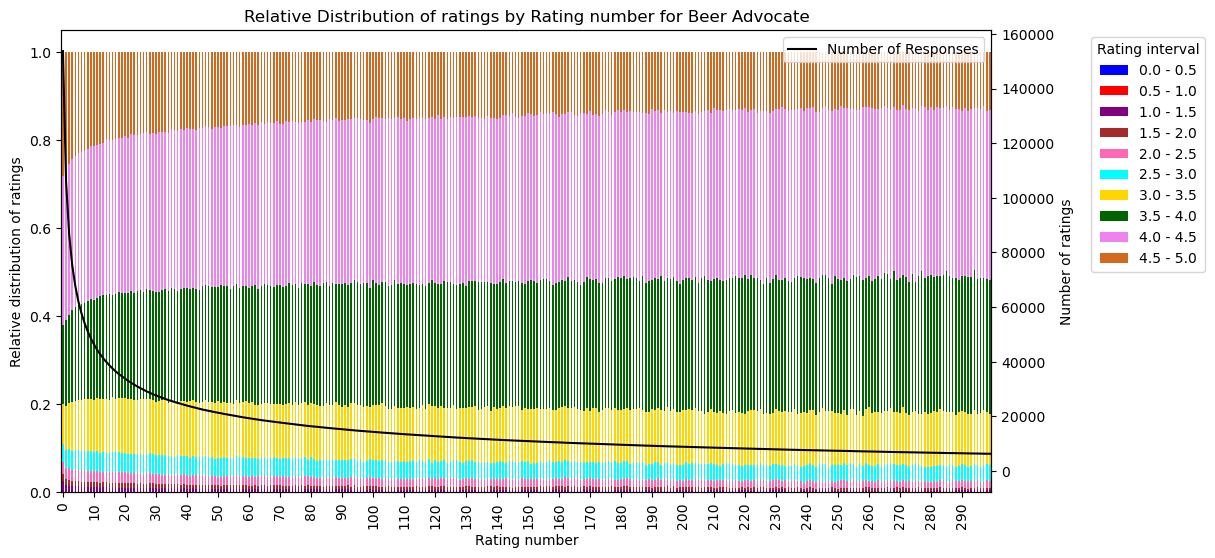

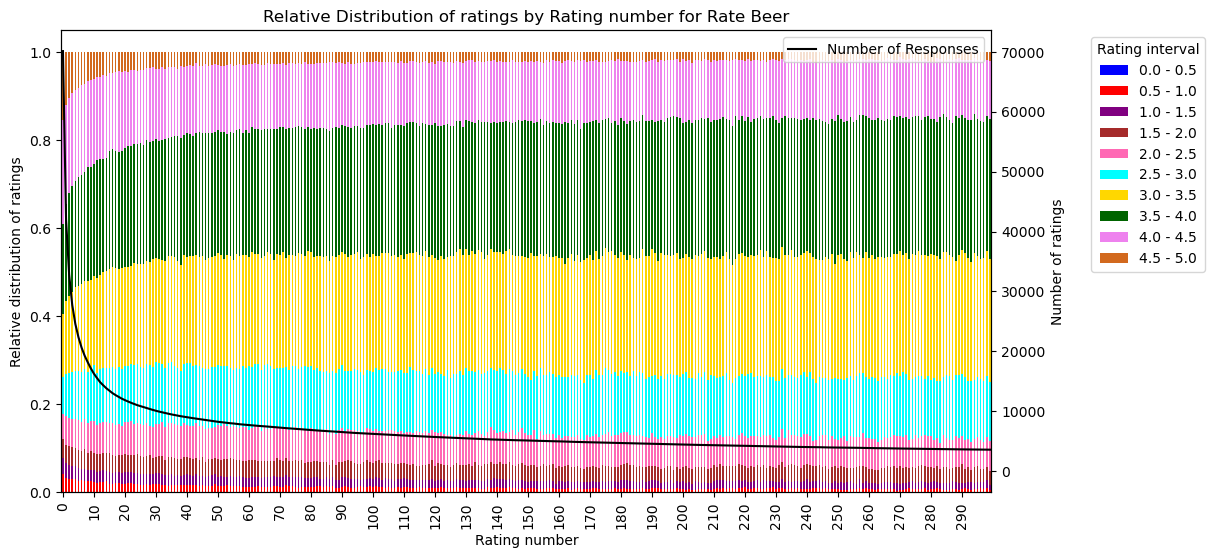

In [3]:
rating_evolution_with_rating_number(df_ba_ratings, 'Beer Advocate')
rating_evolution_with_rating_number(df_rb_ratings, 'Rate Beer')

The plots show that the relative distribution of extreme ratings, such as the top- and bottom-tier, decreases when the rating number increases. We can also see that the reviewers in Beer Advocate tend to provide a higher rating on average, than the reviewers in Rate Beer. Later on we will see that this interesting finding could be due to the difference in the user's origin. Nearly all the users in the BeerAdvocate database are from the US whereas the distribution of the users' origin in Rate Beer is a bit more diverse. Before we make any conclusions on how the number of reviews provided might affect the rating provided, we should look into whether there exists an overall change in the relative distribution of ratings over time regardless of the number of ratings provided earlier on. 

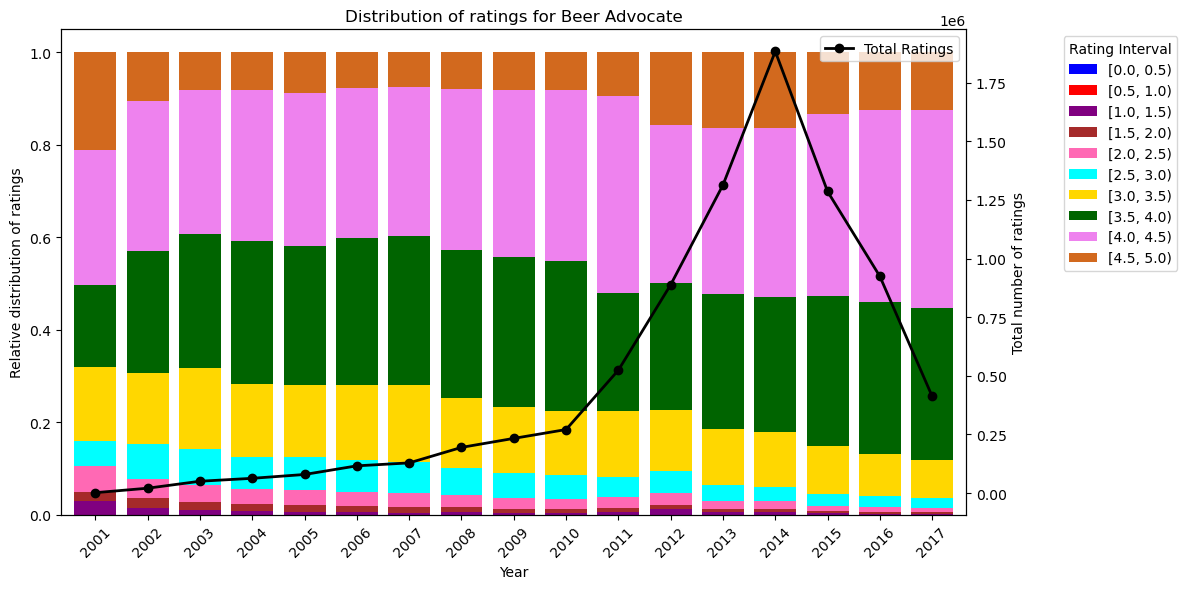

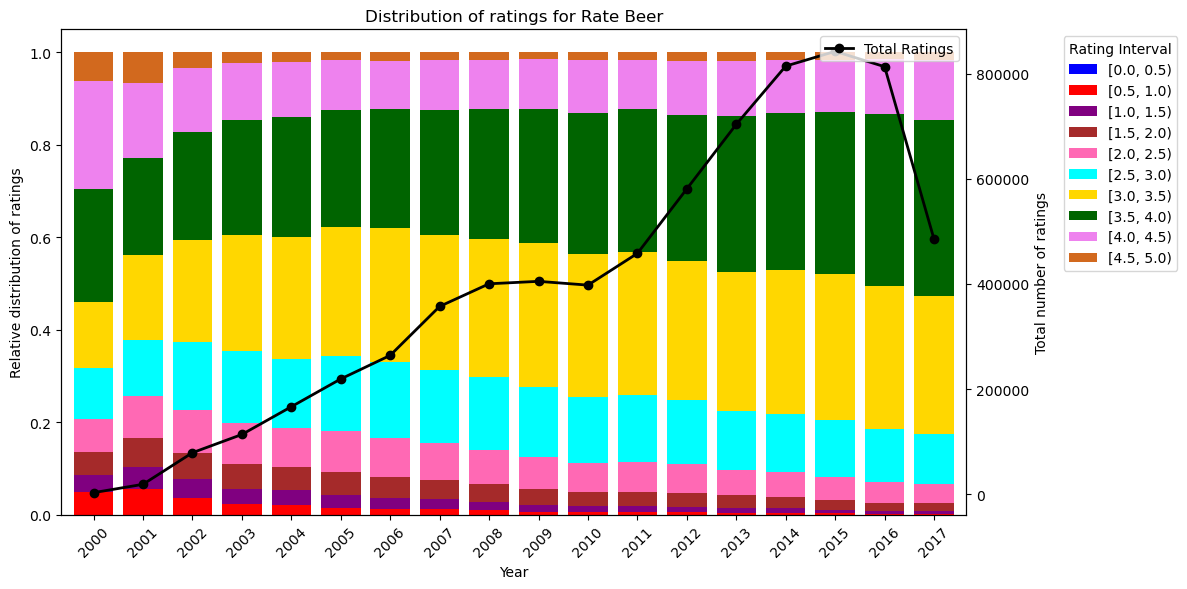

In [42]:
rating_evolution_over_time(df_ba_ratings, 'Beer Advocate')
rating_evolution_over_time(df_rb_ratings, 'Rate Beer')

For the Beer Advocate dataset we can see an opposite tendency of previous finding, as the amount of top-tier ratings increases over time. The previous finding can therefore not be explained only by the change in ratings over time. Furthermore, a high spike in the number of reviews in 2014 indicated that a lot of the users in BeerAdvocate has provided several reviews during that year. 

For the distribution of ratings in the Rate Beer dataset there does seem to be a similar tendency as the previous plot of the relation between rating number and rating distribution. The increase in number of ratings provided exhibits a more linear trend compared to the Beer Advocate dataset. For the Rate Beer dataset we can not conclude that the amount of rating provided is caused by the rating number as there appears to be a similar trend over the years, which could be caused by other factors such as an increase in the amount of premium beers available. If beers in general tend to have a higher standard, this could make it hard to differentiate between the different beers thus could lead to a reduction of top- and bottom-tier ratings over the years.

### 1.2 Experience analysis for 10 most reviewed beers

In the following code, the objective is to work on the 10 most popular beer types and see if a difference of ratings between experienced (defined as at least 15 given ratings) and new reviewers can be seen per type of beer. In contrast to the previous analysis, this study attempts to find if the general trends observed can be seen more locally on a sample of beers. This also aims to see which type of reviewer (new/experienced) dominates the ratings. Only the most reviewed beers were selected (defined as the most popular beers from the BeerAdvocate and RateBeer datasets) in order to have sufficient data for the study.

In [5]:
#For this analysis, the rating files from the previously loaded are used data : 
# df_ba_ratings and df_rb_ratings (which contain the BeerAdvocate and RateBeer ratings)

#The ratings are associated to the users data to find the number of ratings per reviewer
users_BeerAdvocate_df = pd.read_csv("data/BeerAdvocate/users.csv")
users_RateBeer_df = pd.read_csv("data/RateBeer/users.csv")

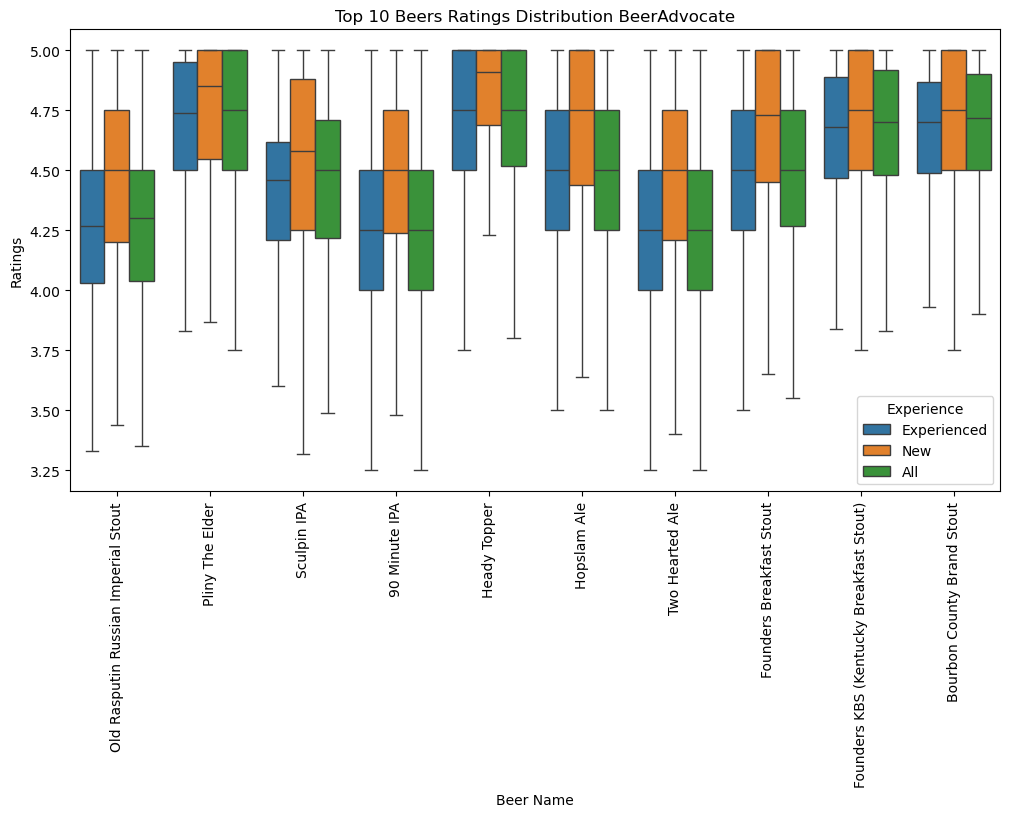

In [6]:
top10beers_ratings(df_ba_ratings, users_BeerAdvocate_df, 'BeerAdvocate')

These results show that the experienced reviewers' ratings tend to follow the general distribution (labelled 'All') of ratings. This seems to indicate that experienced reviewers dominate the general ratings. This could be in part due to the fact that the study does not consider the ratings of experienced reviewers when they were themselves new (instead they are treated as if having always been experienced). In contrast to the experienced ratings, the new reviewers' ratings are always offbeat compared to the general ratings with ratings that are consistently higher for each beer. Since the experience analysis of part 1.1 showed globally more extreme ratings are found with decreasing number of given reviews per reviewer, the observed more positive ratings for new reviewers could correspond to the trend seen in 1.1. It is possible that, if these selected 10 beers are indeed the most popular choices (as it is assumed in this study), new reviewers' rating could be higher compared to experienced reviewers as they might seek or know of more particular or elaborate tastes. In short, it is possible that experienced reviewers have higher standards due to their prior knowledge, thus rating generally lower.

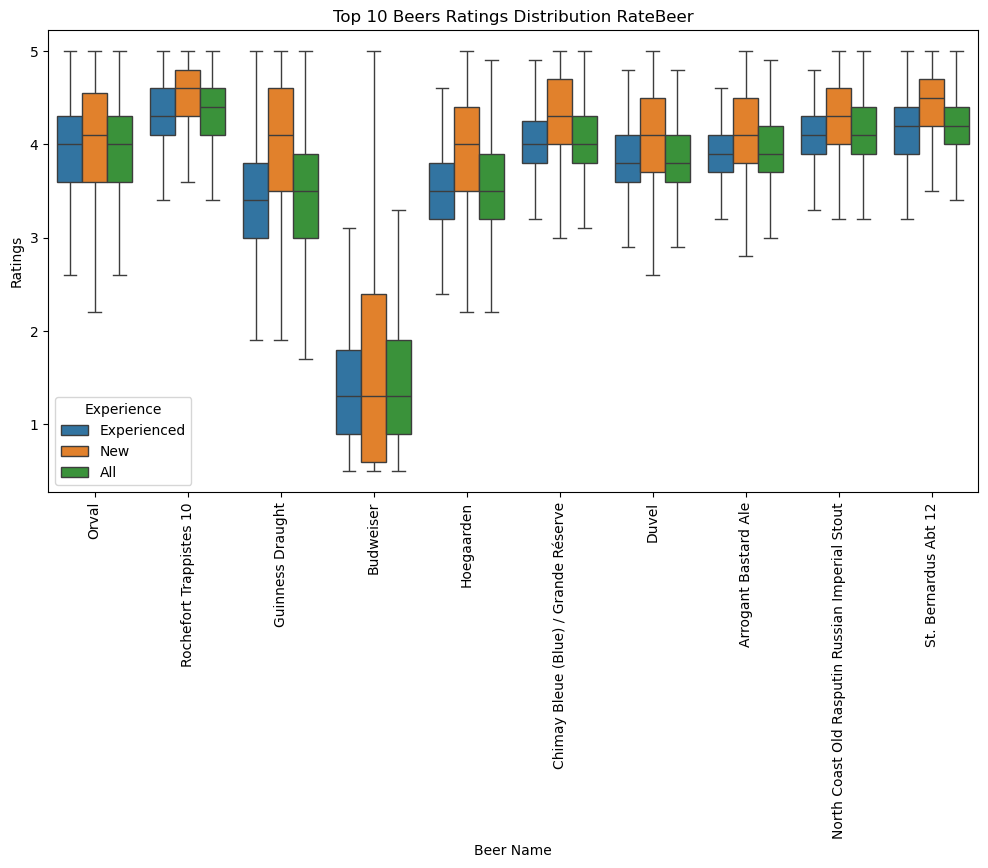

In [7]:
top10beers_ratings(df_rb_ratings, users_RateBeer_df, 'RateBeer')

The results of RateBeer show that new reviewers have ratings generally more dispersed across the median. Once again the experienced reviewers appear to be the main contributors to the general ratings (though it is noted that it can be in part due to experienced reviewers having more concentrated results near the median). New reviewers appear here too to rate higher the different beers, with the notable exception of Budweiser which has a distribution of ratings ranging higher and lower than the general distribution. In the instance of Budweiser, the new reviewers distribution includes ratings with more extreme low grades than the experienced reviewers. Therefor, in the case of RateBeer, new reviewers give the highest and lowest rates which seems to follow the similar trend seen in part 1.1. It is possible that the more spread-out ratings of the new reviewers are a contributing factor to the greater frequency of more extreme ratings found in 1.1 for reviewers that have given less reviews. As with BeerAdvocate it is also possible that experienced reviewers in this instance do not rate lower because they tend to contextualise what is a good or bad beer with a greater selection of past testings.

### 1.3 Analysis of experience based on words in reviews

As we observed, experience seems to play a significant role in how, and particularly how well, individuals rate their beers. However, it is fair to question whether the total number of previous ratings is truly a perfect measure of a user's experience. While it certainly provides a useful indication and is a legitimate estimator, we wondered if there might be a more sophisticated way to identify experienced users. Epecially we wondered if there is maybe a way we could incorporate the text attribute of the ratings to say which users are qualified to be called "experienced". <br> 
As humans, we can often tell whether someone knows what they are talking or writing about, especially when we ourselves have expertise in the subject. This suggests that it might be possible to infer a type of "experience level" from the text of reviews. However, performing an extensive sentiment analysis was beyond our resources, and a similar analysis had already been conducted by the authors of the paper we were provided with ("Learning Attitudes and Attributes from Multi-Aspect Reviews" by Julian McAuley, Jure Leskovec, and Dan Jurafsky, [IEEE Paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6413815)). Our supervisor advised us not to replicate this exact analysis. 
Therefore, we implemented a simpler method to quantify experience in beer reviews.

__A word-based experience metric:__

There are numerous resources on how to describe beer, and for "beer sommeliers," there are even specific guidelines on how to assess and articulate beer characteristics. We searched the internet for a list of terms rarely used in everyday language but frequently employed by beer experts to describe beer. We aimed for a balanced selection of terms meaning that we wanted to have roughly the same number of:

- *Positive Terms* (e.g., "Lacing," which refers to the foam that clings to the inside of a glass)
- *Neutral Terms* (e.g., "Brettanomyces," a wild, non-domesticated yeast)
- *Negative Terms* (e.g., "Diacetyl," an off-flavor that can develop during fermentation)

This balanced approach was intended to avoid introducing bias toward any particular sentiment within the "experienced" group. We compiled our list with significant help from the bachelor’s thesis "Terminology in Beer Reviews" by Malin Norman from the University of Gävle ([Full Text PDF](https://www.diva-portal.org/smash/get/diva2:1294624/FULLTEXT01.pdf)).

__Defining an experienced User:__

Once the vocabulary list was complete, we defined what constitutes an "experienced user" based on two specific criteria:

1. *Usage of at least 5 unique terms*: The user must have used at least five distinct words from our list across all their reviews. This criterion was intended to prevent users who may have simply picked up one or two terms from other reviews from being classified as experienced.
2. *Frequency of term usage*: The user must have used at least one of the terms in a minimum of 10 reviews. This requirement should ensure that only those who consistently and knowledgeably discuss beer were included in the "experienced" group, excluding users who only occasionally or recently began using these terms.

With this definition in place, we were able to proceed with further analyses based on this experience-based classification.
For performance reasons, we are only using the BeerAdvocate dataset here; in the final analysis, we can run the calculation over both datasets (which takes a long time).

In [8]:
from src.models.experience_words import  *
from src.models.foreign_beer import *

In [9]:
# creating the experienced / inexperienced groups
exp_user_ids_ba = get_experienced_users2(df_ba_ratings, exp_words1)
df_ba_ratings_of_exp, df_ba_ratings_of_inexp = split_by_experience(df_ba_ratings, exp_user_ids_ba)

In [10]:
# printing some interesting statistics
print("Number of experienced users: ", len(exp_user_ids_ba))
print("Number of ratings by experienced users: ", len(df_ba_ratings_of_exp))
print("Average rating by experienced users: ", round(df_ba_ratings_of_exp["rating"].mean(), 2))
print("\nNumber of inexperienced users: ", len(df_rb_ratings["user_id"].unique()) - len(exp_user_ids_ba))
print("Number of ratings by inexperienced users: ", len(df_ba_ratings_of_inexp))
print("Average rating by inexperienced users: ", round(df_ba_ratings_of_inexp["rating"].mean(), 2))

Number of experienced users:  3959
Number of ratings by experienced users:  2555996
Average rating by experienced users:  3.82

Number of inexperienced users:  66162
Number of ratings by inexperienced users:  5837036
Average rating by inexperienced users:  3.91


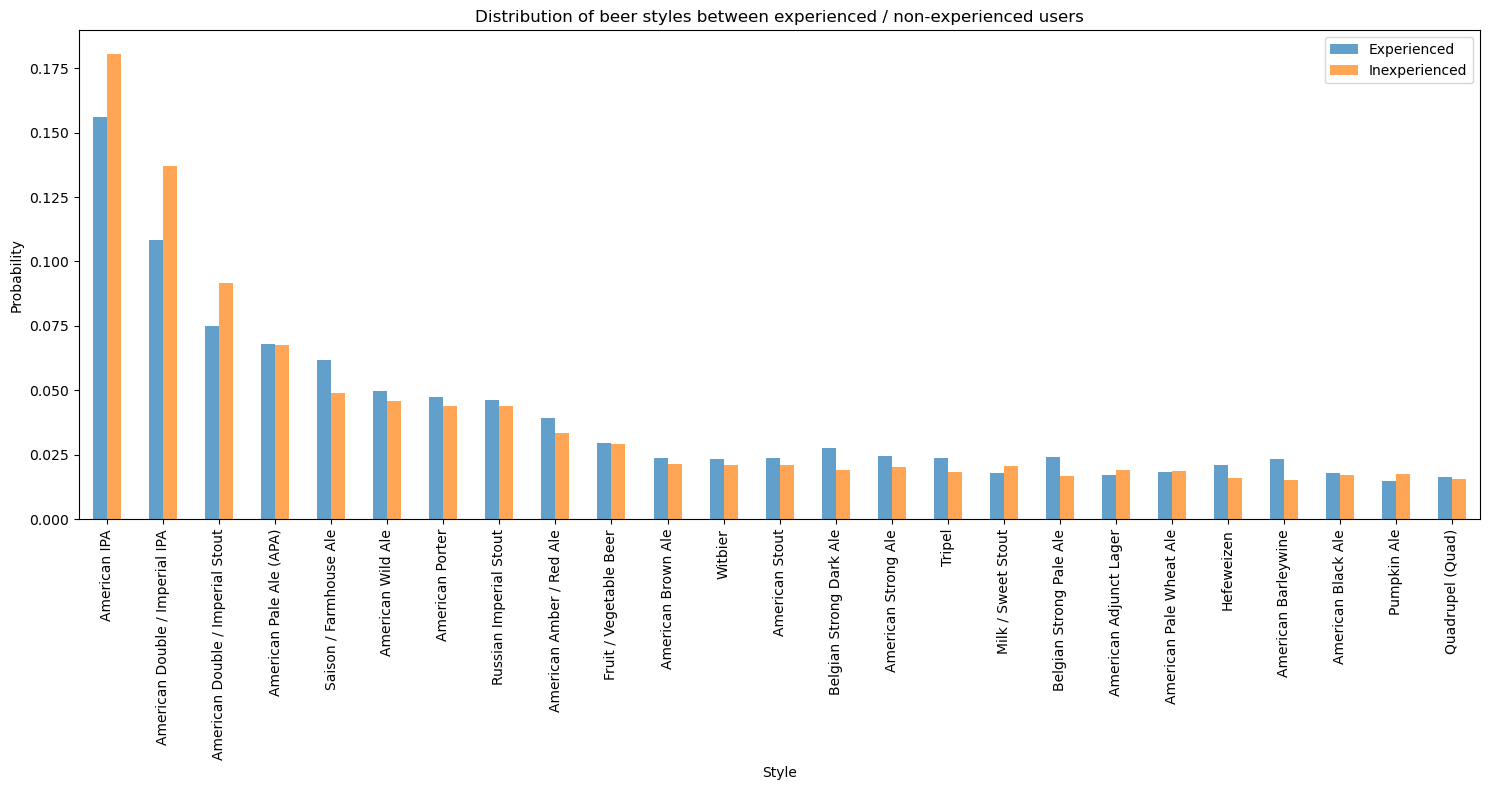

In [11]:
# we calculate an empirical distribution of the number of ratings over the beer styles for both groups and plot it
plot_df, most_rated = calculate_style_distribution(df_ba_ratings_of_exp, df_ba_ratings_of_inexp)
plot_style_distribution(plot_df)

This is already quite interesting. While we can see that the order of which beer styles are consumed more or less frequently is relatively similar between experienced and inexperienced beer drinkers, we also observe that for some beer styles, the frequency at which they are consumed differs significantly between the two groups. This is particularly true for the beer styles that are most popular among both groups.

To examine this further, let’s look at a **difference plot**. In this plot, we will display only one bar per beer style. The length of each bar indicates the difference in consumption frequency between experienced and inexperienced drinkers. The bar points downward if experienced users consume the style relatively less often, and upward if they consume it relatively more.

It’s important to note that this analysis does not reflect absolute frequencies across the entire dataset (as there are significantly more inexperienced users than experienced ones, absolute numbers would not be very informative). Instead, we are subtracting the **relative frequencies** within each group to get a meaningful comparison.


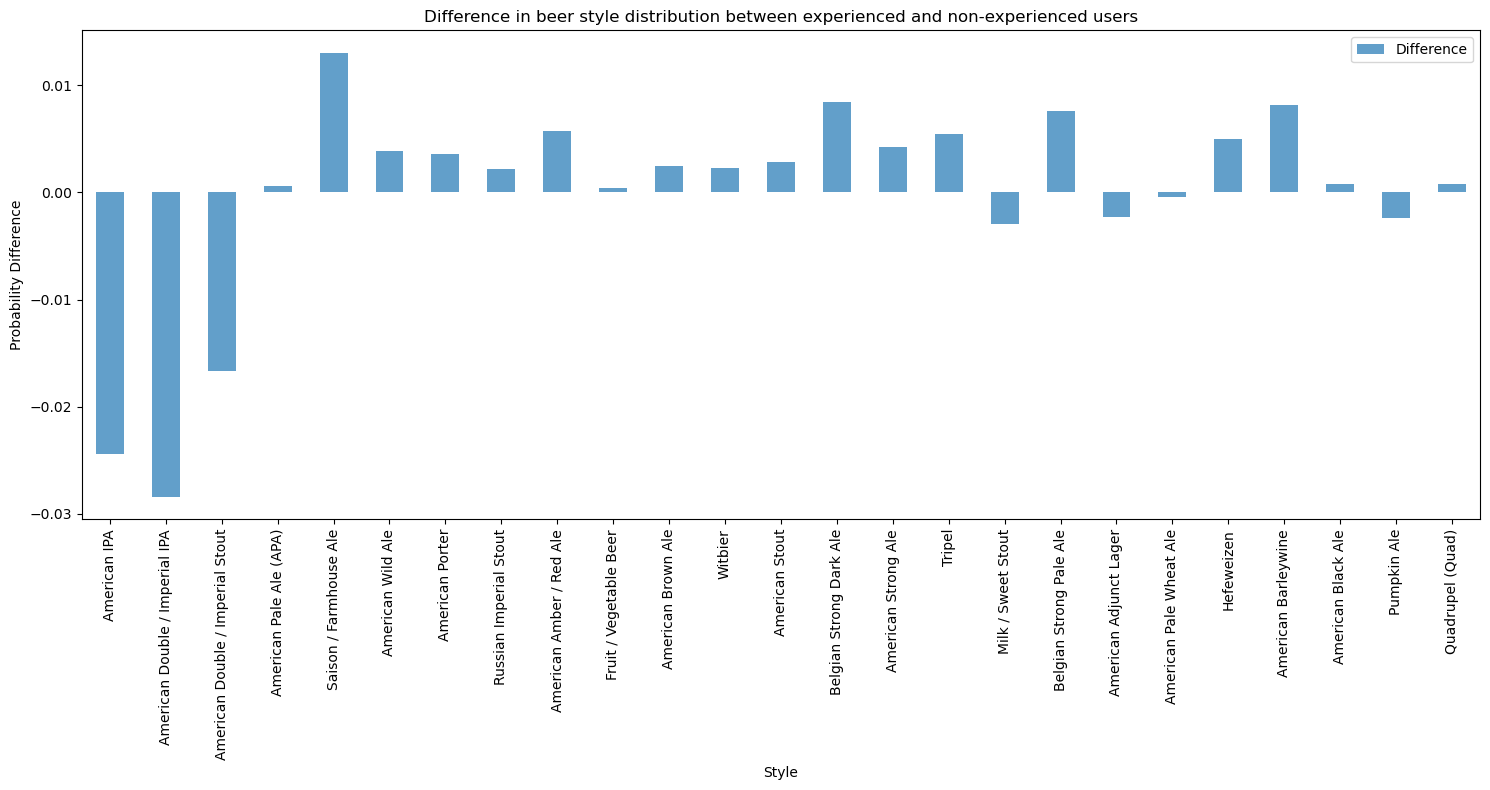

In [12]:
plot_distribution_difference(plot_df)

Now this is truly interesting. We observe that experienced users consume the most popular beer styles—namely, "American IPA," "American Double / Imperial IPA," and "American Double / Imperial Stout"—relatively much less than inexperienced users. However, for the "rarer" beer styles, the opposite trend emerges. 
With just a few exceptions, such as "Milk / Sweet Stout," "American Adjunct Lager," and "Pumpkin Ale", experienced users tend to consume lesser-known beer styles relatively more often than inexperienced users.

Now, let's turn our attention to ratings. In addition to the previous plot, we will now include a second plot (displayed below the first one) showing the **average rating per beer style** for each of the two groups (experienced and inexperienced users).

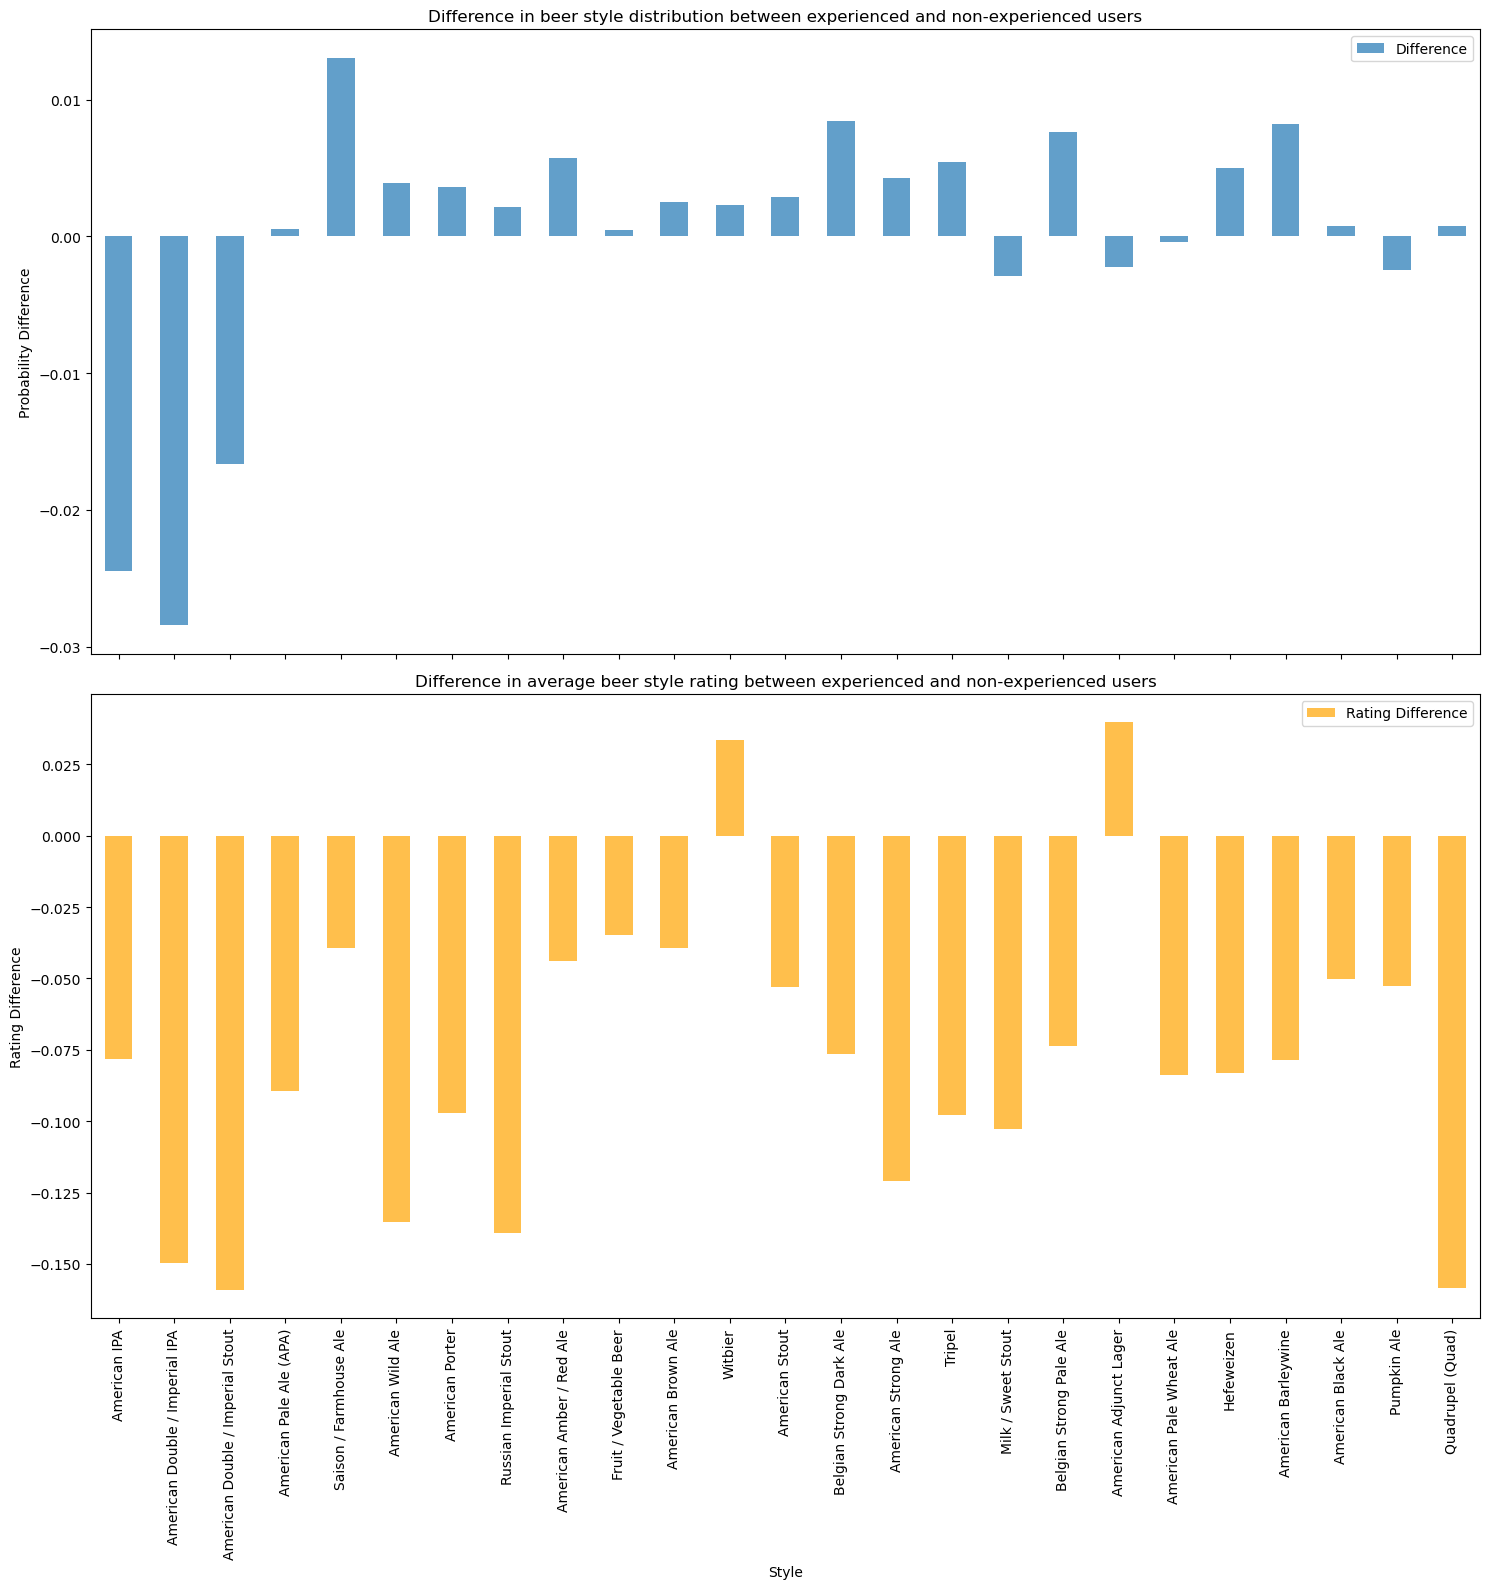

In [13]:
rating_diff_df = calculate_rating_difference(df_ba_ratings_of_exp, df_ba_ratings_of_inexp, most_rated)
plot_combined_distribution_and_rating_difference(plot_df, rating_diff_df)

This plot provides perhaps the most interesting insight we gain from our analysis of classifying experienced users based on their vocabulary. In the upper chart, we see the same (also interesting) information as before. However, in the lower chart, we observe the **average ratings** given per beer style for each group, as previously outlined.

We find that experienced users rate almost all beer styles **lower on average** than inexperienced drinkers, with the exceptions of "Witbier" and "American Adjunct Lager." This suggests that with greater experience, drinkers tend to have higher standards for their beers. Thus, when reading a review from an inexperienced versus an experienced beer drinker for the same beer, one should consider this potential bias in shaping expectations or assessments.
We already observed this difference in average ratings at the beginning when we calculated the overall average rating across all beer styles. Now, however, we can see the breakdown by each individual beer style. This additional information can help us better account for rating bias when assessing a particular review.


## 2. Spatial Reviewer Bias

### 2.1 Examining Beer Patriotism

Another factor we wanted to incorporate into our bias analysis was the extent to which the country of origin of the user, as well as that of the beer, influences the rating. Is there a type of “patriotism effect” in beer ratings, where users rate beers from their own country more favorably than those from abroad? Or is perhaps the opposite the case?

In [14]:
df_ba_users, df_rb_users = load_user_data()
df_rb_sum_rat = calculate_ratings_by_location(df_rb_users)
df_rb_sum_rat_foreign = accumulate_us(df_rb_sum_rat)
df_rb_sum_rat_cutoff = cutoff_and_sort(df_rb_sum_rat_foreign)

In [15]:
plot_location_ratings(df_rb_sum_rat_cutoff)



In the diagram above, we initially displayed the number of ratings from users in various regions. Of course, we applied a cutoff, but this has little impact on the overall interpretability of the data. The country with the fewest ratings that we still included is Cambodia, where we found approximately 2,000 ratings, more than 95% of which come from just two users.

What is especially noticeable is the overwhelming dominance of ratings from users in the USA. This is actually the reason why we are conducting this analysis using the RateBeer dataset. In the BeerAdvocate dataset, this imbalance was even more pronounced, with nearly all ratings coming from U.S. citizens. Here, in this diagram, at least less than half of the ratings are from U.S. citizens.

In [16]:
df_rb_ratings_wo_text = load_rating_wo_text("data/RateBeer/RB_ratings.csv")

df_rb_users_us = accumulate_us2(df_rb_users, "location")
df_rb_users_ratings = merge_users_and_ratings(df_rb_ratings_wo_text, df_rb_users_us)
df_rb_users_ratings_top50, top50 = filter_top_countries(df_rb_users_ratings, top_n=50)

df_plot = avg_rating_by_location(df_rb_users_ratings_top50)

In [17]:
plot_mean_rating_by_location(df_plot)

In this plot, we can see the average rating given by users from the country shown on the x-axis. We observe that, aside from El Salvador (which has very few ratings), most ratings fall between 3.0 and 3.5. However, some differences are still noticeable. Now, one might wonder whether this variation is merely due to the fact that countries at the edges have very few ratings and the result is random error, or if these differences represent actual findings. Let’s investigate this further.

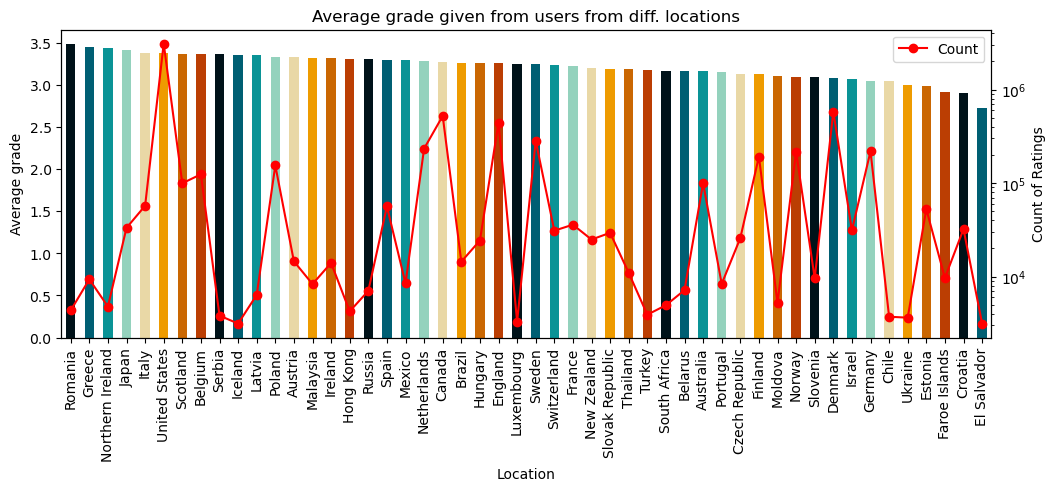

In [18]:
plot_mean_rating_and_rating_count(df_plot, top50)

This is the same plot, but this time with the number of ratings displayed on a log scale (otherwise, most countries' scores are unreadable, and the USA dominates everything). We observe that, while random error could explain the ratings for the two outermost countries (Romania and El Salvador), this does not appear to account for the overall trend.

For example, Croatia, relative to other countries, does not have a particularly low number of ratings, yet its average score is below 3.0. Similarly, Greece has a relatively high number of ratings from users there, yet its average rating remains very close to 3.5.

Now let's start with the analysis that actually interests us, namely the differences between so-called foreign beers, which do not come from the same country as the user who rates them, and own/domestic beers, which come from the user's country

In [19]:
df_brew = load_brewery_data(brewery_path="data/RateBeer/breweries.csv")
df_brew_us = accumulate_us2(df_brew, "brewery_location")
df_rb_users_ratings_brew = merge_ratings_with_breweries(df_rb_users_ratings_top50, df_brew_us)
num_foreign, num_own, foreign_percentage, own_percentage = foreign_beer_stats(df_rb_users_ratings_brew)
print(f"Number of ratings about foreign beers: {num_foreign}")
print(f"Number of ratings about beers from user's country: {num_own}")
print(f"That means {foreign_percentage}% are foreign beers and {own_percentage}% are beers from the user's country.")

Number of ratings about foreign beers: 3145912
Number of ratings about beers from user's country: 3739510
That means 45.69% are foreign beers and 54.31% are beers from the user's country.


We find that the distribution of ratings between foreign and domestic beers is fairly balanced (roughly 46%-54%). This is generally quite good because it allows us to make statements about both groups based on a substantial amount of data. (Incidentally, if we hadn’t aggregated the USA into a single country, more than 80% of the ratings would be for foreign beers, as many users in the USA drink and rate beer from other US states).

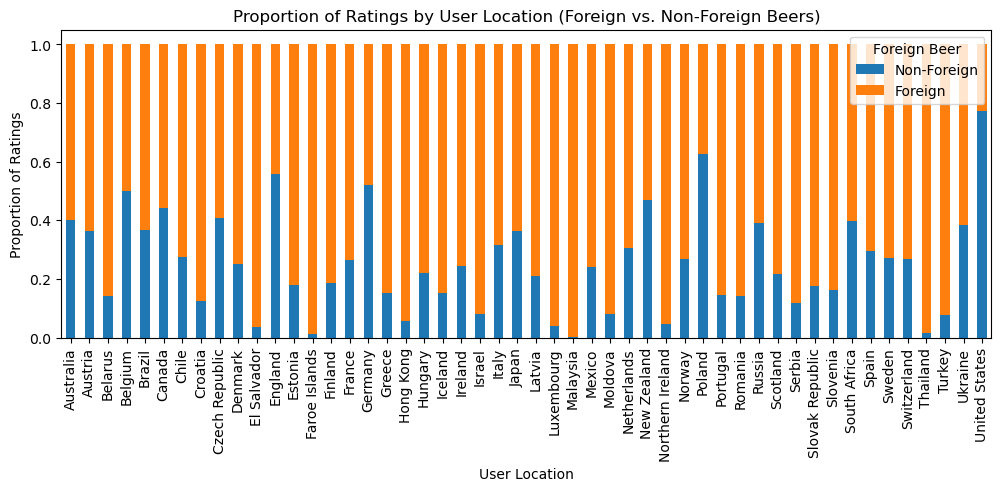

In [20]:
df_grouped_counts = grouped_counts(df_rb_users_ratings_brew)
plot_foreign_vs_own_beer_counts(df_grouped_counts)

The plot above shows, as stacked bars, for the countries with the most user ratings, how many of these ratings are for beers from the user’s country and how many are for beers from abroad. Interestingly, if the USA were excluded, the majority of ratings would clearly be for foreign beers. In the USA, however, around 80% of the ratings are for domestic beers, and because the USA makes up such a large portion of user locations, it can shift the overall ratio to about 50/50 (as seen above). Most other countries have a ratio where foreign beers dominate, though sometimes it’s closer to 50/50 (as in Germany, a country with a strong beer culture).

This is certainly an interesting insight, and it makes sense to some extent. In the USA, the craft beer movement, which likely goes hand in hand with people who write online beer reviews, started the earliest and is thus the most developed. Therefore, there are many beers here that may interest beer reviewers. Additionally, the user location 'United States,' which we aggregated, represents an enormous economic area, almost as if we had grouped all European countries under a single entry, 'Europe.' It makes sense, then, that many of the rated beers come from this economic area and are not imported.

Now, however, we don’t just want to look at the number of ratings but rather focus on the bias in the ratings themselves.
In the following plot, we see the differences between the average rating for domestic beers and foreign beers by users from the country shown on the x-axis.

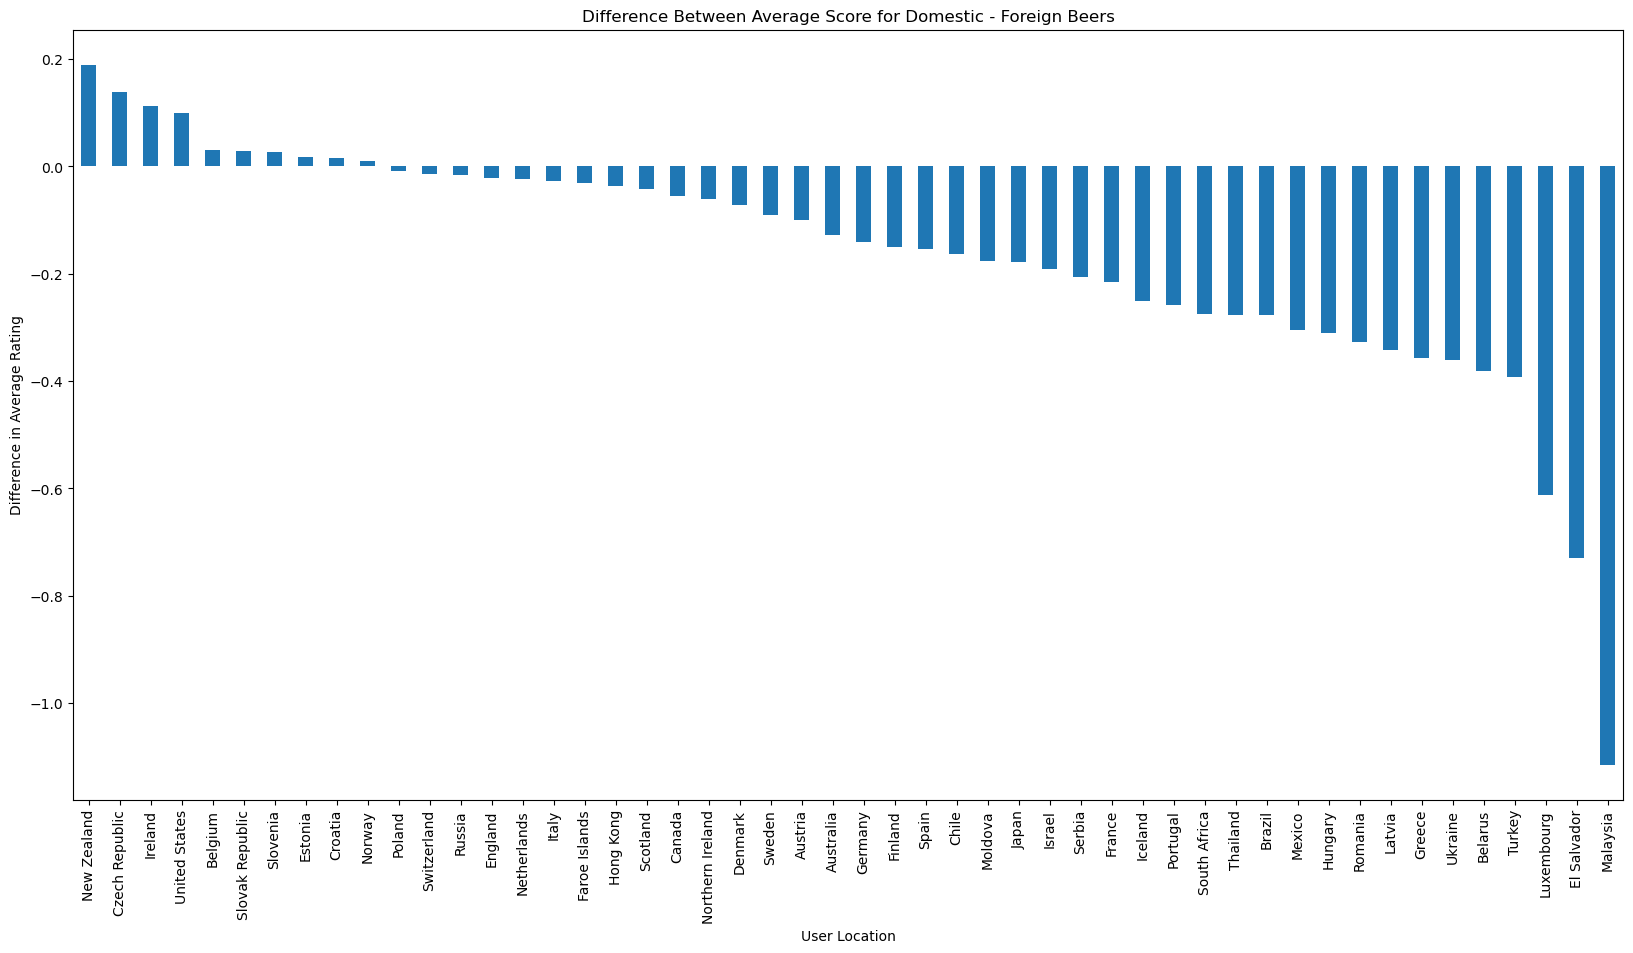

In [21]:
df_rb_users_ratings_brew = change_flag(df_rb_users_ratings_brew)
df_average_scores = avg_scores_domestic_foreign(df_rb_users_ratings_brew)
df_pivot = pivot_average_scores(df_average_scores)
df_pivot_diff = calculate_score_difference(df_pivot)
plot_score_difference(df_pivot_diff)

We observe some noticeable differences here. For instance, residents of New Zealand rate their own beers on average 0.2 points higher than those from outside New Zealand. The USA also rates its own beers on average more than 0.1 points higher than foreign beers. We can also see that the top 4 countries—New Zealand, the Czech Republic, Ireland, and the USA—all rate their own beer more than 0.1 points higher than foreign beer, and these are all countries with a strong sense of national pride.

On the other side of the spectrum, we initially find some more extreme values, such as in Malaysia, where users rate their own beers on average more than a whole point lower. However, we cannot consider these values truly interpretable, as they are based on very small data sets. Still, we find some interesting results here as well. For instance, let’s look at Greece. In a previous analysis, we already found that users from Greece generally give a very high average rating across all their reviews. Additionally, the data set for users from Greece isn’t particularly small (see above). Now, with this plot, we can observe that users from Greece rate their own beer on average almost 0.4 points lower than foreign beer. This is certainly interesting and should be considered when reading a review from Greece, whether it’s for a Greek beer or a foreign one.

In [22]:
best_and_worst_combinations(df_rb_users_ratings_brew)

Combination with the worst average rating::
user_location       United States
brewery_location      El Salvador
avg_rating               1.812202
count_ratings                1090
Name: 5929, dtype: object

Combination with the best average rating:
user_location             Hungary
brewery_location    United States
avg_rating                3.84642
count_ratings                1732
Name: 2533, dtype: object


Here, we’ve displayed the user_location-brewery_location pair with the lowest average rating and the one with the highest. We set a threshold requiring at least 1,000 reviews for each combination; otherwise, it’s considered non-representative. We find that U.S. citizens rate beer from El Salvador surprisingly poorly, with an average score of around 1.8. Conversely, Hungarian citizens rate American beer quite favorably, with an average score of around 3.85. Both are interesting observations that should be considered when evaluating beer ratings from these combinations.

Let’s move on to a final analysis, which focuses on patriotism and attitudes toward foreign beer.

In our previous analyses, we consistently used only the RateBeer dataset. This was because almost all reviews in the BeerAdvocate dataset were from the USA, making such an analysis less meaningful or less reliable. Additionally, in the RateBeer dataset, we aggregated all U.S. states into a single country, so the USA was still by far the country with the most reviews.

However, in this next section, we want to shift our focus to the USA and examine the differences in ratings of domestic versus foreign beer across various U.S. states. For this, we will use data from both datasets.

In [23]:
df_ba_ratings_wo_text = load_rating_wo_text("data/BeerAdvocate/BA_ratings.csv")

df_ba_ratings_w_text = df_ba_ratings
df_rb_ratings_w_text = df_rb_ratings

In [24]:
df_rb_users_ratings_us_only, df_ba_users_ratings_us_only = prepare_datasets(df_rb_users, df_ba_users, df_rb_ratings_w_text, df_ba_ratings_w_text)

Number of ratings from US from BeerAdvocate: 7303870
Number of ratings from US from RateBeer: 3107243


There are some duplicates in the two datasets. We filter them out by removing the entry in the RateBeer dataframe, iff
1. the entry contains no NaN-values in the columns `style`, `brewery_name`, `abv` and `text`.
2. the values that are in these columns are exactly the same as in a row in the BeerAdvocate dataset

In [25]:
# there are some duplicates in the two datasets
df_rb_users_ratings_us_only = filter_usa_duplicates(df_rb_users_ratings_us_only, df_ba_users_ratings_us_only, ["style", "brewery_name", "abv", "text"])
# after filtering duplicates, we don't need the text column anymore
df_rb_users_ratings_us_only = df_rb_users_ratings_us_only.drop(columns=["text"])
df_ba_users_ratings_us_only = df_ba_users_ratings_us_only.drop(columns=["text"])

Number of duplicates:  709


In [26]:
df_ba_brew = load_brewery_data(brewery_path="data/BeerAdvocate/breweries.csv")

In [27]:
df_us_only = merge_with_brewery(df_rb_users_ratings_us_only, df_ba_users_ratings_us_only, df_brew, df_ba_brew)
# the foreign column now only tells, whether the beer comes from the exact same US state or not
# maybe this will be interesting for future analyses, but I will add a new column called "is_us_beer"
# containing the information whether the beer comes from the US
df_us_only = avg_ratings_us(df_us_only)

Number of ratings from US: 10410404
Avg rating for US beer: 3.771623765815906
Avg rating for non-US beer: 3.5902842691414762


This is an interesting initial finding. In a previous analysis, we already found that U.S. citizens rate their own beer on average more than 0.1 points higher than foreign beer (though this analysis was only for the RateBeer dataset). Now, with both datasets combined, we can see precise figures, and the difference is even more pronounced at around 0.18 points. 'Beer patriotism' in the U.S. thus appears to be quite strong. Let’s take a closer look at this, broken down by individual U.S. states.

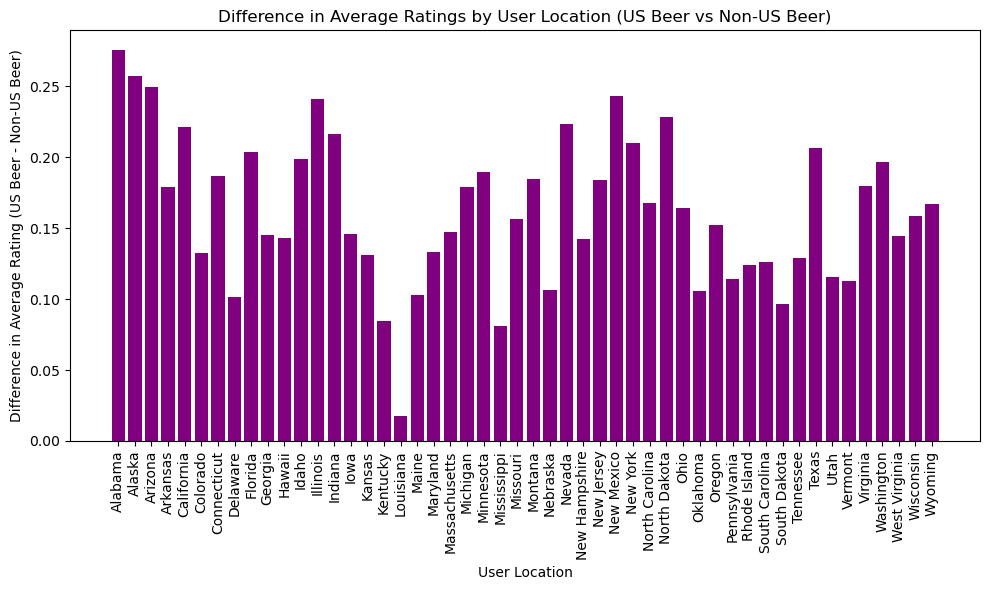

In [28]:
avg_ratings_per_location = avg_ratings_per_location_us(df_us_only)
plot_avg_ratings_per_location(avg_ratings_per_location)

This finding becomes even stronger here. There isn’t a single U.S. state that rates foreign beer higher than its own (although the difference in Louisiana is negligible). I find this quite impressive. There actually seems to be a kind of bias in the U.S. against non-American beer.

We also wondered: in the U.S., there is a politically diverse landscape. The Southern states are generally considered more patriotic and are core states for the Republicans, the more conservative of the two major U.S. parties. So, might there be a difference in how citizens of Northern states and citizens of Southern states rate beer?

In [29]:
average_ratings = north_south_avg(df_us_only)
average_ratings

is_us_beer,Foreign Beer,US Beer
region,,
North,3.618942,3.795068
Other,3.563876,3.751468
South,3.565090,3.739550


There is a difference in the rating of American and non-American beers between the Northern and Southern states, with both differences being around 0.175. However, it is noticeable that both categories are rated lower in the Southern states than in the Northern states.

### 2.2 Distance Analysis

Taking a closer look at the foreign versus abroad reviewing behavior of our reviewers revealed some interesting country specific insights. Let's take a look at less discrete but a more numeric approach in which we take into account the actual estimated distance between the reviewers location and the breweries' location.

In [30]:
from src.models.distance_analysis import *

In [31]:
df_ba_users, df_rb_users = load_user_data()
df_ba_ratings, df_rb_ratings = load_rating_data()

In [32]:
df_brewery_ba = load_brewery_data(brewery_path="data/BeerAdvocate/breweries.csv")
df_brewery_rb = load_brewery_data(brewery_path="data/RateBeer/breweries.csv")

In [33]:
joined_rb_df = join_users_breweries_ratings(df_rb_users, df_brewery_rb, df_rb_ratings, ratebeer=True)
joined_ba_df = join_users_breweries_ratings(df_ba_users, df_brewery_ba, df_ba_ratings, ratebeer=False)

After joining all the available datasets together to get for each beer review the users domestic country as well as the location of the regarding beer brewery. To derive distances from the country / state names, we rely on using the Web-API 'Nominatim' which is embedded in the 'GeoPy' python library.

In [34]:
df_location = retrieve_location_data(joined_ba_df, joined_rb_df)
joined_ba_df = calculate_distances(joined_ba_df, df_location)
joined_rb_df = calculate_distances(joined_rb_df, df_location)

Now, the rating behavior in regard to the distance brewing location and user registration location can be plotted. To align with our hypothesis that people more regularly dislike beer from abroad, we would to see this trend in the stacked bar plot, too.

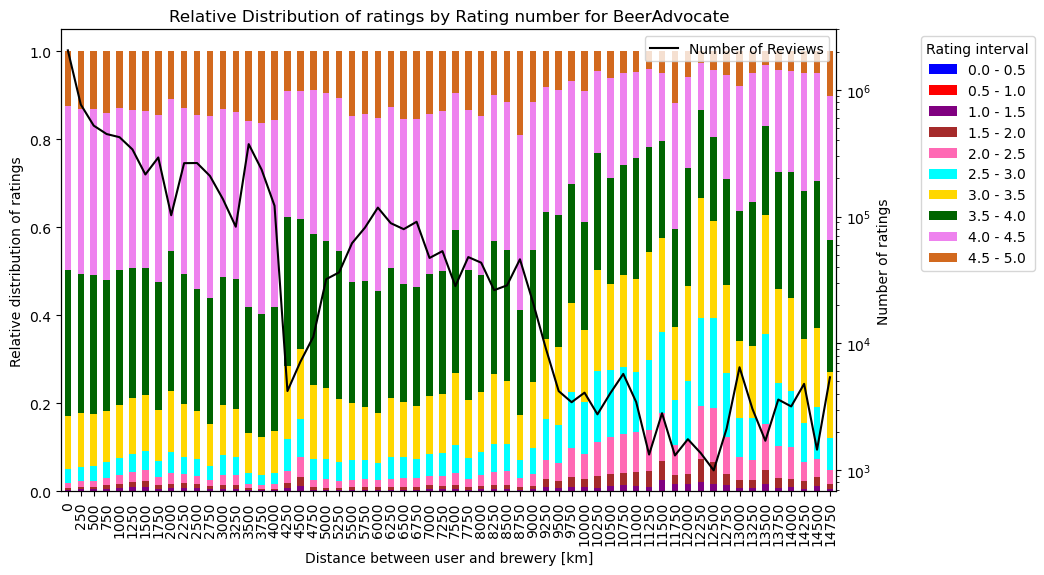

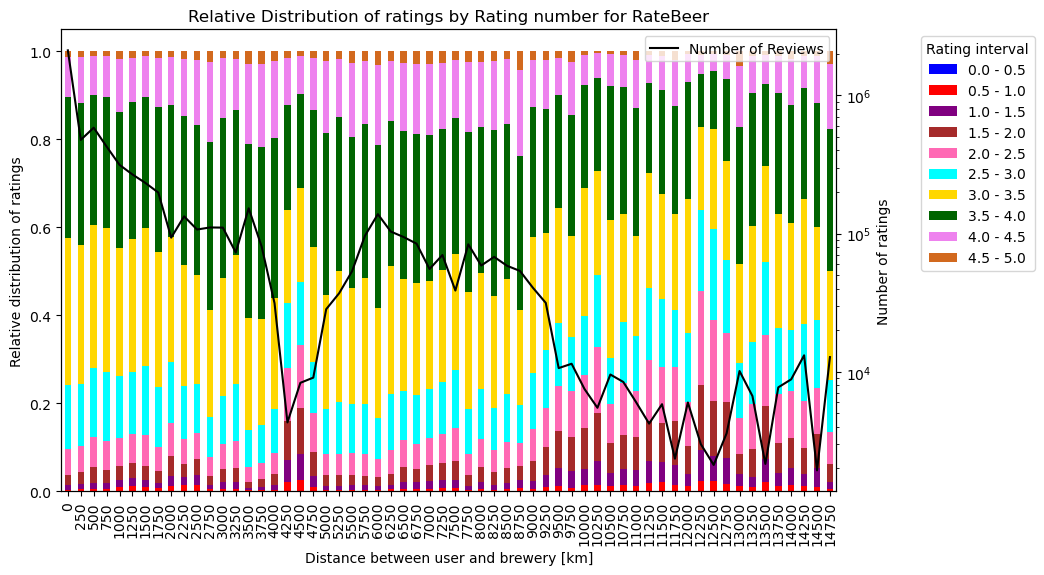

In [35]:
plot_distance_ratings(joined_ba_df, ratebeer=False)
plot_distance_ratings(joined_rb_df, ratebeer=True)

Indeed, we can find some downwards rating trends in the data. One is apparent in the distance between 4,250 - 4,750 km. However, the plot also shows a drastic decrease in the number of ratings, which could be explained by the distance between U.S. and Europe. Another tendency to worse beer rating can be seen from about 9,000 kilometers in both the BeerAdvocate and the RateBeer dataset. 

## 3. Influence of the Season

### 3.1 Influence of the season on average rating

Next we look at whether the time of year, the season, has any influence on ratings. We grouped the ratings into months, as a less fine grained division into quarters would be very ingranular, and not enable us to see how trends develop as the year progresses, while a grouping into weeks or days would produce a lot of data and big dataframes. Let's first explore, if the time of year leads to a general rating "high" or "low", for example reviewers being more satisfied with their beer in the summer rather than the winter.

In [36]:
from src.models.seasonality_analysis import *

In [37]:
df_rb_ratings = pd.read_csv("data/RateBeer/RB_ratings.csv", usecols=lambda col: col != "text")

   month    rating
0      1  3.299755
1      2  3.302308
2      3  3.305359
3      4  3.294649
4      5  3.304360


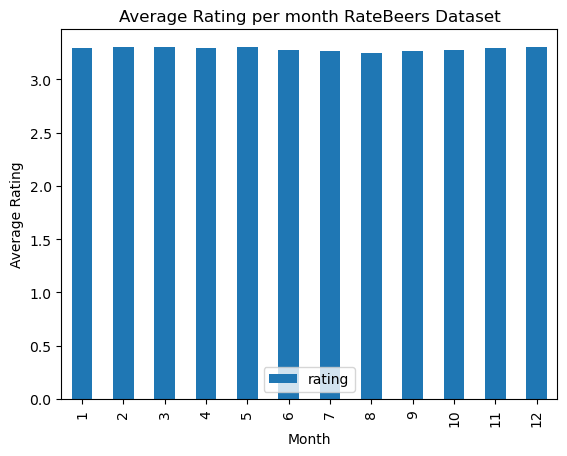

In [38]:
plot_and_head_average_rating_per_month(df_rb_ratings)

We see that the average ratings do not change with the month, at least not significantly, thus the hypothesis that the time of year has a general effect on the ratings in total does not hold, rather the results are kind of boring. However, lets also have a look at how the beers get rated throughut the year depending on the beer style. 

### 3.2 Influence on the Season for Ratings for Individual Beer Styles

Before we analyse the rating, let's first check which beer is a "summery" beer and which beers are "wintery", by comparing the amount of each reviewed by month. The graph below filters out beer styles which do not show a difference of at least 14 ranks throughout the entire year, in order to not crowd the graph with straight and uninteresting lines. The value of 14 was chosen as it offers a nice balance between not hiding important data and now not crowding the graph. The function also removes beer styles which have less than 500 reviews for at least one month, in order to not flood the analysis with beers which have few reviews, where the change in review count might not be significant.

In [39]:
plot_beer_style_ranking_by_amount(df_rb_ratings, 500, 14)

We lost 169 rows by filtering out styles with less than 500 reviews.


Beers such as :
- Czech Pilsner, 
- Session IPA, 
- Grodziskie, 
- Kölsch and 
- Radler/Shandy

are rated more frequently in the summer, while:

- English Strong Ale, 
- Dunkler Bock and  
- Old ale 
are reviewed more frequently in the winter. 

There is also a fun peak of Oktoberfestbeer during the months of September and Oktober, whcih (coincidentally?) coincides with the dates of the Oktoberfest celebrations, in which many cities celebrate the Oktoberfest-related festivals. With this in mind, lets have a look at how the ratings change across the year.

Similarly to the previous graph, we have introduced a review count cutoff of 500, and beers with only a slight change in rating, in this case 0.1 points, are filtered out.

In [40]:
plot_beer_style_ranking_by_avg_score(df_rb_ratings, 500, 0.1)

We lost 169 rows by filtering out styles with less than 500 reviews.


The graph shows barely interesting result. As the rating is out of 5, even slight changes in rating may be significant, a significance test will be performed in the future, however we can not see obvious peaks and throughs like in the previous graph. Also, many the fluctuating beers in this graph are not present in the previous one, suggesting that the difference in average score is independent of the season. Here too, an independence test may be performed in the future.

An interesting, rather funny, obervation that we make from the graph is however, that Oktoberfestbeer is rated less high during Oktoberfest season. What might the reason for that be...

## 4 Predicting beer taste - analyses using Machine Learning

### 4.1 Goal

Several ADA lectures covered machine learning and methods for applying machine learning in data analysis. Furthermore, a significant portion of our data consists of text data. There are numerous machine learning methods to utilize text data and extract information from it.

Throughout our analysis, we examined various types of biases that might influence a user to rate a beer better or worse. Now, we aim to put this acquired knowledge to practical use. One example of how such insights could be utilized is by providing users with suggestions for which beer they might want to try next. It's certainly not a new revelation to state that consumer biases also influence purchasing decisions. Consider, for instance, the stigmas associated with certain countries of origin for products, which many people factor into their purchasing choices.

However, the advertising industry naturally aims to maximize the likelihood that a customer will buy a beer. Therefore, any prediction about which beer a user might enjoy should also incorporate such bias features. Additionally, this final step can serve as a conclusive analysis to determine whether users are truly biased. By investigating whether our model can better predict which beer a user will like with the help of bias features compared to without them (spoiler: the bias features provide a significant accuracy boost), we can validate our hypothesis. But one step at a time.

The following describes the machine learning model we developed—a neural network—that attempts to predict whether a user would rate a particular beer higher or lower than their current average rating. This can provide insights into whether the user perceives the beer as above or below average. We chose such a classification approach because training is often easier compared to directly performing regression for the given rating. How much a user will like a beer can still be estimated in our model based on how confident the model is before applying a threshold.

### 4.1 Feature extraction

The first step was to determine which features should be used for prediction—essentially, what features to provide as input to the neural network. It would be unrealistic to assume the model could achieve high accuracy solely based on bias features, so we included some non-bias features as well. In particular, we wanted to make further use of text data. The features we created are as follows:

1. Distributions
We created a list of words commonly used to describe beer positively or negatively. Words like "malty" or "acidic" are often used by beer enthusiasts to express a positive or negative opinion about a beer. Additionally, we included the words used to identify **experienced users** from Section 1.3. This resulted in a list of 77 words.
For a given user, we divided their ratings into two categories:
a) Ratings strictly below 2.8 (considered **bad ratings**).
b) Ratings strictly above 3.7 (considered **good ratings**).
We calculated the empirical distribution of the words from our list in the texts associated with these **good** and **bad ratings**.
The same process was applied to a given beer. We considered all ratings received by the beer and divided them into those with scores below 2.8 and those with scores above 3.7. For both, we calculated the word distributions. 
From these distributions, we generated two types of features:
**a) Inner Products**
We calculated the inner product of the **user's good ratings distribution** with the **beer's good ratings distribution**. A high inner product suggests that the beer possesses attributes the user strongly appreciates, making this a valuable feature. 
Similarly, we calculated the inner product for the distributions derived from **bad ratings**. For example, if a user often describes beers they dislike as "acidic" and the beer is frequently described as "acidic" by other users, this feature will have a high value.
**b) Distributions in Latent Space**
We also fed the distributions themselves into the model as input features (i.e., the frequencies of specific words). However, providing the relative frequency of all 77 words directly would result in 308 features (77 words × 4 distributions). This would slow down training and introduce redundancy (since empirical distributions must sum to 1). 
To address this, we projected the distributions into a **latent space**. Each distribution was passed through a multi-layer perceptron (MLP) with a single linear layer, reducing the dimensionality from 77 to 15. 
Initially, we chose a latent space with 5 dimensions but observed that increasing the dimensions improved model predictions. This indicates that the word distributions themselves carry significant informational value. A latent space of 15 dimensions was found to be the sweet spot.

2. User Bias Features
These features capture information about the potential biases of the user, including:

- **user_num_ratings**: The number of ratings the user has submitted, as an indicator of their experience (see Analysis 1.1 and 1.2).
- **user_is_exp**: A binary feature indicating whether the user is classified as an experienced user based on the word metrics established in Section 1.3.
- **user_mean**: The average rating the user has given to all beers they reviewed before the beer we are attempting to predict.
- **user_style_mean**: The average rating the user has given to beers of the same style as the beer we are attempting to predict (calculated only from past ratings).

3. Additional Bias Features
- **month**: The month (encoded as a one-hot vector with 12 features, where one is set to 1 and the rest to 0). This was identified as a bias feature in the **seasonality analysis** in Section 3.
- **distance**: The user-to-brewery distance, analyzed in Section 2.2.

4. Beer-Specific Features
- **beer_mean_rating**: The average rating given to the beer by all other users.
- **beer_one_hot_cat**: A one-hot vector with 13 categories. Initially, the BeerAdvocate dataset contained 104 beer styles. Including all of them as one-hot values would be excessive, so we aggregated them into 10 broader categories. 

  However, three beer styles—**American IPA**, **American Double/Imperial IPA**, and **American Double/Imperial Stout**—occurred significantly more frequently than the others. Thus, we treated these styles as their own categories, resulting in 13 one-hot values.

---
By combining these features, we ensured that the model could leverage both text-based and bias-related information for accurate predictions.


### 4.3 The model


### 4.4 Results